# Simple Python example: shear frame

In [1]:
import koma.oma, koma.plot

import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import detrend, welch

import pandas as pd

## System definition

In [2]:
K = np.array([[8000, -8000,0], [-8000, 16000, -8000], [0, -8000, 16000]])
C = np.array([[10, 0,0], [0, 10, 0], [0, 0, 10]])
M = np.array([[500,0,0], [0, 500,0], [0, 0, 500]])

## Analytical eigenvalue solution

[0.5617449  0.20048443 0.13873953]


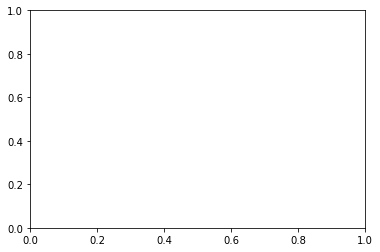

In [3]:
from knutils.modal import statespace as to_A

A = to_A(K, C, M) # establish state matrix based on K, C and M
lambdai, qi = np.linalg.eig(A)

ix = np.argsort(np.abs(lambdai))
xi = -np.real(lambdai)/np.abs(lambdai)

print(xi[ix[::2]]*100)

## Load data and define input


In [4]:
# Import and specify properties of input data
df = pd.read_csv('shear_frame_simulation.csv', sep=',',header=None)
data = df.values      # data including noise
fs = 3.0
t = np.arange(0,1/fs*(data.shape[0]),1/fs)

# Cov-SSI settings
i = 20
s = 4
orders = np.arange(2, 50+2, 2)
stabcrit = {'freq':0.2, 'damping': 0.2, 'mac': 0.3}

# Noise specification
noise_factor = 1.0

## Add artificial noise and plot response

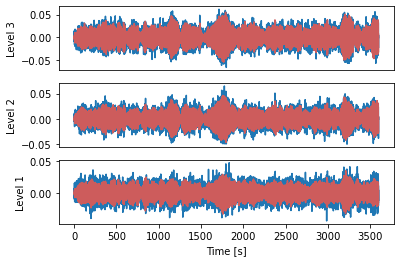

In [5]:
noise = np.std(data) * noise_factor
data_noised = data + noise*np.random.randn(data.shape[0], data.shape[1])

fig, ax = plt.subplots(nrows=3, ncols=1, num=1)
ax[0].plot(t, data_noised[:,0])
ax[0].plot(t, data[:,0], color='IndianRed', alpha=1)
ax[1].plot(t, data_noised[:,3])
ax[1].plot(t, data[:,3], color='IndianRed', alpha=1)
ax[2].plot(t, data_noised[:,6])
ax[2].plot(t, data[:,6], color='IndianRed', alpha=1)

__ = [a.set_xticks([]) for a in ax[0:2]]
__ = ax[2].set_xlabel('Time [s]')

__ = ax[0].set_ylabel('Level 3')
__ = ax[1].set_ylabel('Level 2')
__ = ax[2].set_ylabel('Level 1')

## Cov-SSI call

In [6]:
lambd, phi = koma.oma.covssi(data_noised, fs, i, orders) # find poles by Cov-SSI
lambd_stab, phi_stab, orders_stab, ix_stab = koma.oma.find_stable_poles(lambd, phi, orders, s, stabcrit=stabcrit, indicator='mac') # Stable poles

*** Covariance-driven SSI algorithm for OMA ***
> Establishing Hankel/Toeplitz matrices
  >> Correlation estimation
  >> Matrix stacking
> Establishing weighting matrices
  >> Weighting requested: NONE
> Computing SVD
> Computing state matrix for each order to establish modes
> Computation completed


## Welch PSD estimate

In [7]:
nperseg = 1024
zp = 4
nfft = nperseg*zp

f, Pxx = welch(data_noised[:,0], fs, 'hanning', nperseg=nperseg, nfft=nfft)

## Visualization: stabilization plot

In [9]:
fig = koma.plot.stabplot(lambd_stab, orders_stab, renderer=None, psd_freq=f, psd_y=Pxx, frequency_unit='Hz', freq_range=[0,1.5], damped_freq=False)
fig

FigureWidget({
    'data': [{'hovertemplate': 'f_n = %{x:.2f} Hz<br>n = %{y}<br> %{text}',
              'mark…

As seen, the analytical critical damping ratios are 0.5617449% (mode 1), 0.20048443% (mode 2), and 0.13873953% (mode 3). The stabilization plot shows experimental data with reasonable agreement!

If you want to be able to use interactive selection of poles (append to table)- uses the following syntax in your IPython environment:

	
`fig = koma.plot.stabplot(lambd_stab, orders_stab, renderer=None, psd_freq=f, psd_y=Pxx, 
    frequency_unit='Hz', freq_range=[0,1.5], to_clipboard='ix', damped_freq=False)`
    
`fig`

This generates the following interactive interface:
![title](stabplot_interactive.png)

(This is not used above because it does not export well for static online docs)

# Pole clustering
By using pole clustering tecniques available in the `clustering` module, you can obtain modal results without any manual selection. The module is based on the HDBSCAN method, and relies on the `hdbscan` python package. The two cells below show how the module is used to automatically identify estimates of the three modes of ours system.

In [22]:
import koma.clustering
pole_clusterer = koma.clustering.PoleClusterer(lambd_stab, phi_stab, orders_stab, scaling={'xi':1.0, 'mac':1.0, 'omega_n':1.0})
prob_threshold = 0.0    #probability of pole to belong to cluster, based on estimated "probability" density function
args = pole_clusterer.postprocess(prob_threshold=prob_threshold)
xi_auto, omega_n_auto, phi_auto, order_auto, probs_auto, ixs_auto = koma.clustering.group_clusters(*args)
xi_mean = np.array([np.mean(xi_i) for xi_i in xi_auto])
fn_mean = np.array([np.mean(om_i) for om_i in omega_n_auto])/2/np.pi

xi_std = np.array([np.std(xi_i) for xi_i in xi_auto])
fn_std = np.array([np.std(om_i) for om_i in omega_n_auto])/2/np.pi


In [23]:
# Print table
import pandas as pd
res_data = np.vstack([fn_mean, 100*xi_mean]).T
results = pd.DataFrame(res_data, columns=['f_n [Hz]', r'$\xi$ [%]'])
results

,f_n [Hz],$\xi$ [%]
0,0.28,0.48
1,0.90,0.18


In [24]:
# Group only a selected quantity (e.g. indices)
lambd_used, phi_used, order_stab_used, group_ixs, all_single_ix, probs = pole_clusterer.postprocess(prob_threshold=prob_threshold)
grouped_ixs = koma.clustering.group_array(all_single_ix, group_ixs)       # for instance the indices only,
grouped_phis = koma.clustering.group_array(phi_used, group_ixs, axis=1)   # or the phis only